In [2]:
import torch
import torch.nn as nn

## Simple version

For the setting with `bidirectional = False` and `batch_first = False`:

LSTM expect arguments in the following form: `lstm(x, (h_0, c_0))`
- `x (seq_len x batch_size x input_dim)`: input
- `h_0 (num_layers x batch_size x hidden_dim)`: the initial hidden state for each element in the input sequence
- `c_0 (num_layers x batch_size x hidden_dim)`: the initial cell state for each element in the input sequence

You can also omit `batch_size` dim from all.

In [123]:
torch.manual_seed(0)

num_layers = 1
batch_size = 1

seq_len = 5
input_dim = 3
hidden_dim = 2

model = nn.LSTM(input_size=input_dim, 
                hidden_dim=hidden_dim, 
                num_layers=num_layers)

seq = [torch.randn(batch_size, input_dim) for _ in range(seq_len)]
init_hidden = (torch.randn(num_layers, batch_size, hidden_dim), 
               torch.randn(num_layers, batch_size, hidden_dim))


In [124]:
hidden = init_hidden

# Iterating over each element in the sequence one-by-one
for element in seq:
    # Expected input size
    # Note on view vs reshape: https://stackoverflow.com/a/49644300
    assert element.view(1, batch_size, -1).shape == (1, batch_size, input_dim)
    
    # Expected hidden size
    assert len(hidden) == 2
    assert hidden[0].shape == (num_layers, batch_size, hidden_dim)
    
    # Pass inputs to the model
    out, hidden = model(element.view(1, batch_size, -1), hidden)
    
    # out: output features from the last layer of lstm
    assert out.shape == (1, batch_size, hidden_dim)
    
    # hidden: (h_t, c_t) - similar to initial state
    assert len(hidden) == 2
    assert hidden[0].shape == (num_layers, batch_size, hidden_dim)
    
    
one_by_one_last_layer_out = out[0].detach()
one_by_one_hidden_state = hidden[0].detach()
one_by_one_cell_state = hidden[1].detach()

print("out:", out.detach())
print("hiddens:", hidden[0].detach(), hidden[1].detach())

out: tensor([[[ 0.0712, -0.1522]]])
hiddens: tensor([[[ 0.0712, -0.1522]]]) tensor([[[ 0.1088, -0.3212]]])


In [125]:
# Alternative: Passing all sequence at once

# Reshape input from a list of 2D tensor to a 3D tensor
inputs = torch.cat(seq).view(seq_len, batch_size, -1)
assert torch.cat(seq).shape == (seq_len * batch_size, input_dim)
assert inputs.shape == (seq_len, batch_size, input_dim)

# Initialize hidden states
hidden = init_hidden

# Pass inputs to the model
out, hidden = model(inputs, hidden)

# out: output features from the last layer of lstm
assert out.shape == (seq_len, batch_size, hidden_dim)
print("output shape:", out.shape)

all_seq_last_layer_out = out[-1].detach()
all_seq_hidden_state = hidden[0].detach()
all_seq_cell_state = hidden[1].detach()

print("out:", out[-1].detach())
print("hiddens:", hidden[0].detach(), hidden[1].detach())


# Assert two version of iterating works the same
assert torch.equal(one_by_one_last_layer_out, all_seq_last_layer_out)
assert torch.equal(one_by_one_hidden_state, all_seq_hidden_state)
assert torch.equal(one_by_one_cell_state, all_seq_cell_state)


output shape: torch.Size([5, 1, 2])
out: tensor([[ 0.0712, -0.1522]])
hiddens: tensor([[[ 0.0712, -0.1522]]]) tensor([[[ 0.1088, -0.3212]]])


## Bidirectional LSTM

In a bidirectional LSTM, the input will be processed in two directions, namely forward and backward. \
The backward pass is similar to forward pass, but it passes the input tokens in reverse order.

We will have two hidden state and cell state for each layer, so the hidden state shape will be:
- `h_0 ((num_layers*2) x batch_size x hidden_dim)`
- `c_0 ((num_layers*2) x batch_size x hidden_dim)`

The output will also take the shape of `(seq_len x batch_size x (hidden_dim*2))` instead of `(seq_len x batch_size x hidden_dim)`.

In [354]:
# Alternative: Passing all sequence at once
torch.manual_seed(0)

# We have two directions, we'll need to multiply 
D = 2

num_layers = 1
batch_size = 1

seq_len = 5
input_dim = 3
hidden_dim = 2

model = nn.LSTM(input_size=input_dim, 
                hidden_size=hidden_dim, 
                num_layers=num_layers,
                bidirectional=True)

seq = [torch.randn(batch_size, input_dim) for _ in range(seq_len)]

# Need to initialize hidden states for both forward and backward, thus the multiplication by 2
init_hidden = (torch.randn(num_layers * D, batch_size, hidden_dim), 
               torch.randn(num_layers * D, batch_size, hidden_dim))

inputs = torch.cat(seq).view(seq_len, batch_size, -1)
hidden = init_hidden

# Pass inputs to the model
out, hidden = model(inputs, hidden)

# out: output features from the last layer of lstm
# output will be the concatened version of outputs of forward and backward LSTMs
assert out.shape == (seq_len, batch_size, hidden_dim * D)

print("output shape:", out.shape)

output shape: torch.Size([5, 1, 4])


## Training

Test the model using sinusoidal function.

In [355]:
import matplotlib.pyplot as plt

torch.Size([200, 300, 1])
torch.Size([200, 2])


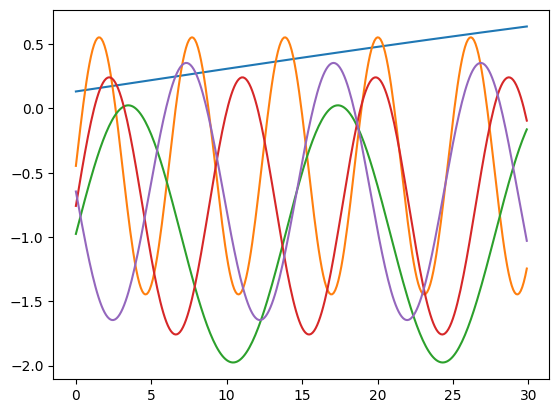

In [356]:
count = 200
seq_len = 300

all_x = []
all_y = []

for i in range(count):
    points = torch.arange(seq_len) / 10
    y = torch.randn(2)
    x = torch.sin(points * y[0]) + y[1]

    if i < 5:
        plt.plot(points, x)
        
    all_x.append(x)
    all_y.append(y)
    
all_x = torch.concat(all_x).reshape(count, -1, 1)
all_y = torch.concat(all_y).reshape(count, -1)

print(all_x.shape)
print(all_y.shape)

In [357]:
batch_size = int(count * 0.8)
train_x, test_x = all_x[:batch_size], all_x[batch_size:]
train_y, test_y = all_y[:batch_size], all_y[batch_size:]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([160, 300, 1]) torch.Size([160, 2])
torch.Size([40, 300, 1]) torch.Size([40, 2])


In [358]:
torch.manual_seed(0)

D = 1
num_layers = 1
input_dim = train_x.shape[-1]
hidden_dim = 2

# Need to initialize hidden states for both forward and backward, thus the multiplication by 2
init_hidden = (torch.randn(num_layers * D, batch_size, hidden_dim, requires_grad=True), 
               torch.randn(num_layers * D, batch_size, hidden_dim, requires_grad=True))


We will use `batch_first = True` here since our input is of size `(batch_size x seq_len x input_dim)`

In [359]:
class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional, seq_len, output_dim):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        
        D = 2 if bidirectional else 1
        
        self.linear = nn.Linear(seq_len*hidden_dim*D, output_dim)
        
    def forward(self, x):
        out, h = self.lstm(x)
        reshaped_out = out.reshape(out.shape[0], -1)
        return self.linear(reshaped_out)
    
model = MyModel(input_dim=input_dim,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=D==2)

In [360]:
out, h = model.lstm(train_x, init_hidden)

assert out.shape == (batch_size, seq_len, hidden_dim * D)
assert h[0].shape == (num_layers * D , batch_size, hidden_dim)

In [361]:
out = model(train_x)
assert out.shape == (batch_size, 2)

In [362]:
loss_fn = torch.nn.MSELoss()
points = torch.arange(seq_len) / 10

def train(model, train_x, train_y):
    epochs = 1000
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        preds = model(train_x)
        loss = loss_fn(preds, train_y)
        print(f"Epoch {epoch} | Loss: {loss.detach()}")
        
        if loss < 1e-3:
            print(f"Early stopping at epoch {epoch}, loss: {loss.detach()}")
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 30 == 0:
            pred_y = preds[0].detach()
            pred_x = torch.sin(points * pred_y[0]) + pred_y[1]

            plt.plot(points, pred_x, alpha=epoch/epochs, color="blue")
    
    y = train_y[0]
    true_x = torch.sin(points * y[0]) + y[1]
    plt.plot(points, true_x, color="green")
    plt.show() 
    return model   

def test(model, test_x, test_y):
    preds = model(test_x)
    loss = loss_fn(preds, test_y)
    
    print(f"Test loss: {loss}")

    y = test_y[0]
    pred_y = preds[0].detach()
    true_x = torch.sin(points * y[0]) + y[1]
    pred_x = torch.sin(points * pred_y[0]) + pred_y[1]

    plt.plot(points, true_x, color="green")
    plt.plot(points, pred_x, color="pink")
    plt.show()

Epoch 0 | Loss: 0.9865995645523071
Epoch 1 | Loss: 0.6452773213386536
Epoch 2 | Loss: 0.6690564751625061
Epoch 3 | Loss: 0.6994962096214294
Epoch 4 | Loss: 0.5860501527786255
Epoch 5 | Loss: 0.5050610899925232
Epoch 6 | Loss: 0.48393192887306213
Epoch 7 | Loss: 0.4957757890224457
Epoch 8 | Loss: 0.5044480562210083
Epoch 9 | Loss: 0.48634225130081177
Epoch 10 | Loss: 0.44205155968666077
Epoch 11 | Loss: 0.3967787027359009
Epoch 12 | Loss: 0.373272567987442
Epoch 13 | Loss: 0.37325024604797363
Epoch 14 | Loss: 0.37960711121559143
Epoch 15 | Loss: 0.3715667128562927
Epoch 16 | Loss: 0.34415706992149353
Epoch 17 | Loss: 0.3121504783630371
Epoch 18 | Loss: 0.29310402274131775
Epoch 19 | Loss: 0.28984951972961426
Epoch 20 | Loss: 0.2899716794490814
Epoch 21 | Loss: 0.28098586201667786
Epoch 22 | Loss: 0.2623189091682434
Epoch 23 | Loss: 0.243051216006279
Epoch 24 | Loss: 0.23151814937591553
Epoch 25 | Loss: 0.22755666077136993
Epoch 26 | Loss: 0.2245754897594452
Epoch 27 | Loss: 0.2170369923

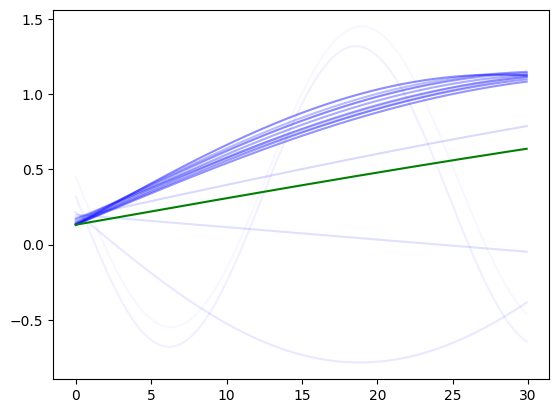

Test loss: 0.004343277774751186


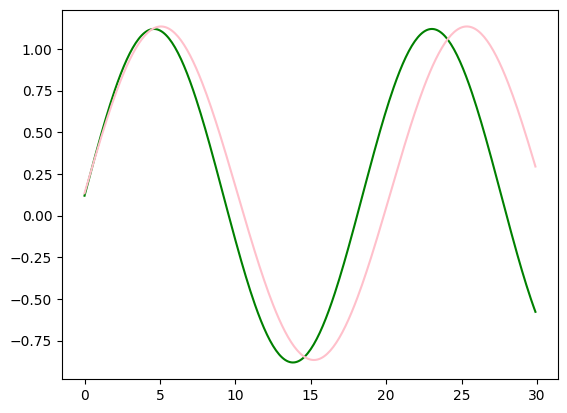

In [363]:
model = MyModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=1,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=False)

train(model, train_x, train_y)
test(model, test_x, test_y)

Epoch 0 | Loss: 1.2993077039718628
Epoch 1 | Loss: 1.4926551580429077
Epoch 2 | Loss: 0.888674259185791
Epoch 3 | Loss: 0.7925958037376404
Epoch 4 | Loss: 0.7817609906196594
Epoch 5 | Loss: 0.7686161994934082
Epoch 6 | Loss: 0.707133412361145
Epoch 7 | Loss: 0.6273693442344666
Epoch 8 | Loss: 0.55625319480896
Epoch 9 | Loss: 0.49666404724121094
Epoch 10 | Loss: 0.45338526368141174
Epoch 11 | Loss: 0.43313947319984436
Epoch 12 | Loss: 0.43490296602249146
Epoch 13 | Loss: 0.44661012291908264
Epoch 14 | Loss: 0.45038604736328125
Epoch 15 | Loss: 0.4345921576023102
Epoch 16 | Loss: 0.4011504054069519
Epoch 17 | Loss: 0.3619045615196228
Epoch 18 | Loss: 0.3302365839481354
Epoch 19 | Loss: 0.3146187365055084
Epoch 20 | Loss: 0.31563347578048706
Epoch 21 | Loss: 0.32620105147361755
Epoch 22 | Loss: 0.33519595861434937
Epoch 23 | Loss: 0.3334619998931885
Epoch 24 | Loss: 0.31883764266967773
Epoch 25 | Loss: 0.2967440187931061
Epoch 26 | Loss: 0.2760947346687317
Epoch 27 | Loss: 0.2636361122131

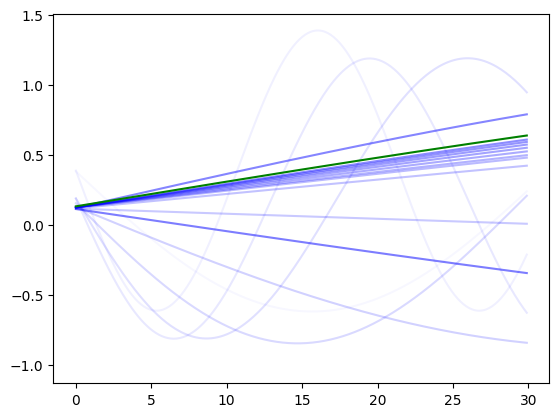

Test loss: 0.00670603895559907


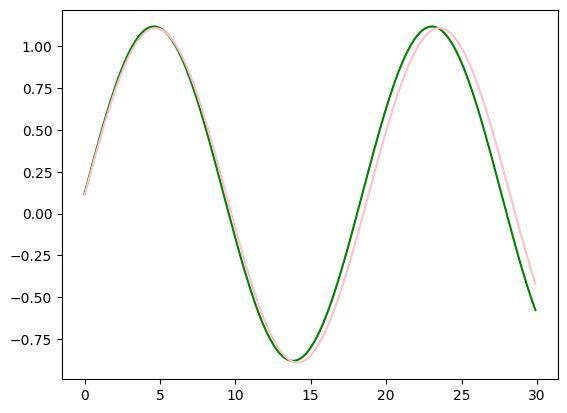

In [364]:
# Testing bidirectional

model = MyModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=1,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=True)

train(model, train_x, train_y)
test(model, test_x, test_y)

Epoch 0 | Loss: 1.054528832435608
Epoch 1 | Loss: 7.376961708068848
Epoch 2 | Loss: 0.7172307968139648
Epoch 3 | Loss: 3.973231792449951
Epoch 4 | Loss: 3.7031447887420654
Epoch 5 | Loss: 1.5826642513275146
Epoch 6 | Loss: 0.48009419441223145
Epoch 7 | Loss: 0.641839325428009
Epoch 8 | Loss: 1.2304269075393677
Epoch 9 | Loss: 1.5078538656234741
Epoch 10 | Loss: 1.3320558071136475
Epoch 11 | Loss: 0.9566086530685425
Epoch 12 | Loss: 0.6426799893379211
Epoch 13 | Loss: 0.49209585785865784
Epoch 14 | Loss: 0.47715210914611816
Epoch 15 | Loss: 0.5248536467552185
Epoch 16 | Loss: 0.5756310224533081
Epoch 17 | Loss: 0.6025173664093018
Epoch 18 | Loss: 0.604813277721405
Epoch 19 | Loss: 0.5935032963752747
Epoch 20 | Loss: 0.5787721276283264
Epoch 21 | Loss: 0.5636650323867798
Epoch 22 | Loss: 0.5445277690887451
Epoch 23 | Loss: 0.5166376829147339
Epoch 24 | Loss: 0.48041826486587524
Epoch 25 | Loss: 0.4425078332424164
Epoch 26 | Loss: 0.4113294184207916
Epoch 27 | Loss: 0.39187386631965637
Ep

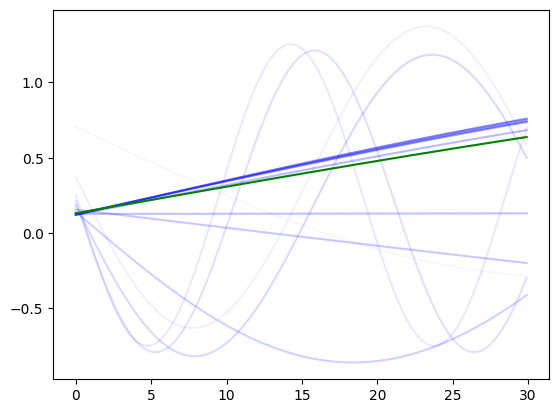

Test loss: 0.005721851717680693


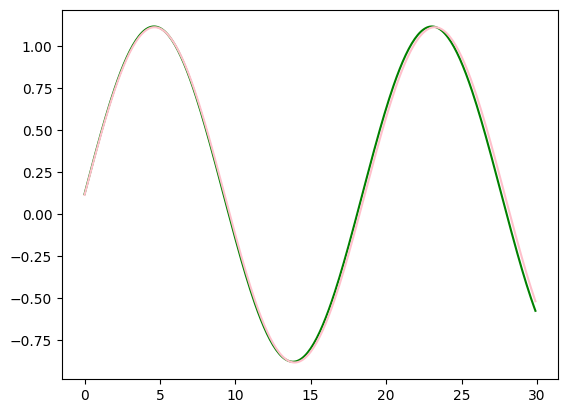

In [365]:
# Using higher hidden dim

model = MyModel(input_dim=input_dim,
                hidden_dim=10,
                num_layers=1,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=False)

train(model, train_x, train_y)
test(model, test_x, test_y)

Epoch 0 | Loss: 1.0316568613052368
Epoch 1 | Loss: 2.287630319595337
Epoch 2 | Loss: 1.0865061283111572
Epoch 3 | Loss: 1.1789172887802124
Epoch 4 | Loss: 1.482428789138794
Epoch 5 | Loss: 1.4226642847061157
Epoch 6 | Loss: 1.2040331363677979
Epoch 7 | Loss: 1.0455721616744995
Epoch 8 | Loss: 1.0003879070281982
Epoch 9 | Loss: 1.031651496887207
Epoch 10 | Loss: 1.0860275030136108
Epoch 11 | Loss: 1.125217318534851
Epoch 12 | Loss: 1.1335132122039795
Epoch 13 | Loss: 1.1140947341918945
Epoch 14 | Loss: 1.0799009799957275
Epoch 15 | Loss: 1.0445114374160767
Epoch 16 | Loss: 1.0168585777282715
Epoch 17 | Loss: 1.0001742839813232
Epoch 18 | Loss: 0.9933966398239136
Epoch 19 | Loss: 0.9931573867797852
Epoch 20 | Loss: 0.9953875541687012
Epoch 21 | Loss: 0.9963787198066711
Epoch 22 | Loss: 0.9934101104736328
Epoch 23 | Loss: 0.9850192070007324
Epoch 24 | Loss: 0.9709411859512329
Epoch 25 | Loss: 0.9517914652824402
Epoch 26 | Loss: 0.9286286234855652
Epoch 27 | Loss: 0.9025410413742065
Epoch 

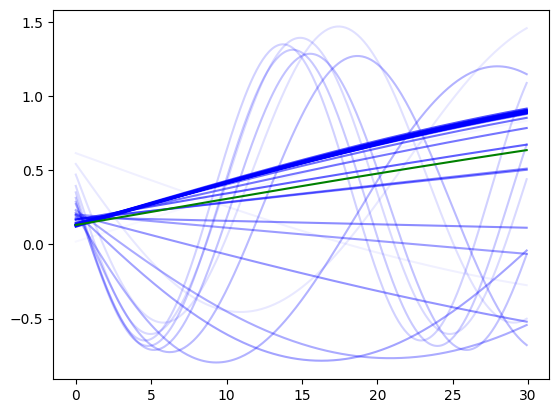

Test loss: 0.0011251682881265879


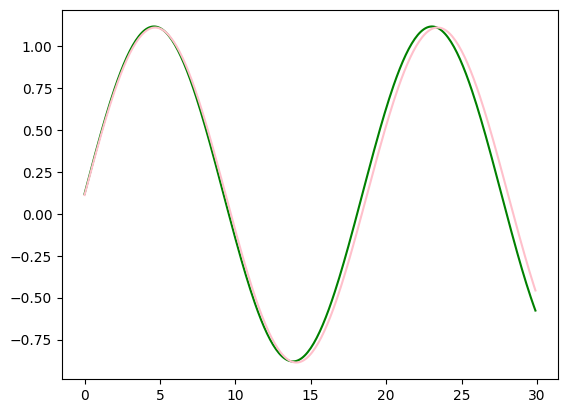

In [366]:
# Using more layers

model = MyModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=3,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=False)

train(model, train_x, train_y)
test(model, test_x, test_y)

Epoch 0 | Loss: 1.0630590915679932
Epoch 1 | Loss: 1.4552128314971924
Epoch 2 | Loss: 1.0556354522705078
Epoch 3 | Loss: 1.0785692930221558
Epoch 4 | Loss: 1.210892677307129
Epoch 5 | Loss: 1.1466951370239258
Epoch 6 | Loss: 1.0252890586853027
Epoch 7 | Loss: 0.9848152995109558
Epoch 8 | Loss: 1.0242068767547607
Epoch 9 | Loss: 1.0603307485580444
Epoch 10 | Loss: 1.0434725284576416
Epoch 11 | Loss: 0.9929419755935669
Epoch 12 | Loss: 0.9503402709960938
Epoch 13 | Loss: 0.9367289543151855
Epoch 14 | Loss: 0.9439573287963867
Epoch 15 | Loss: 0.9503268003463745
Epoch 16 | Loss: 0.9407490491867065
Epoch 17 | Loss: 0.9152780771255493
Epoch 18 | Loss: 0.8840972781181335
Epoch 19 | Loss: 0.8576133847236633
Epoch 20 | Loss: 0.839749813079834
Epoch 21 | Loss: 0.8272746205329895
Epoch 22 | Loss: 0.8137760162353516
Epoch 23 | Loss: 0.7946383357048035
Epoch 24 | Loss: 0.769546389579773
Epoch 25 | Loss: 0.7415143251419067
Epoch 26 | Loss: 0.7141018509864807
Epoch 27 | Loss: 0.6891810297966003
Epoch

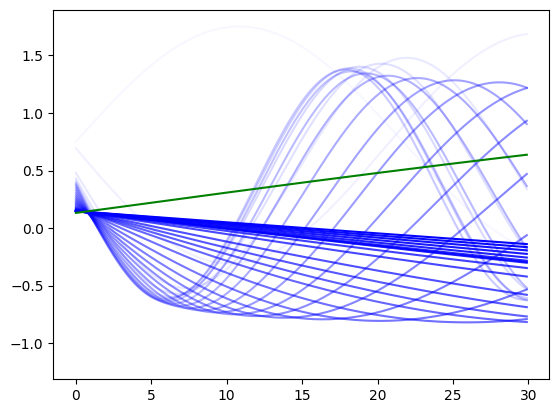

Test loss: 0.0018182698404416442


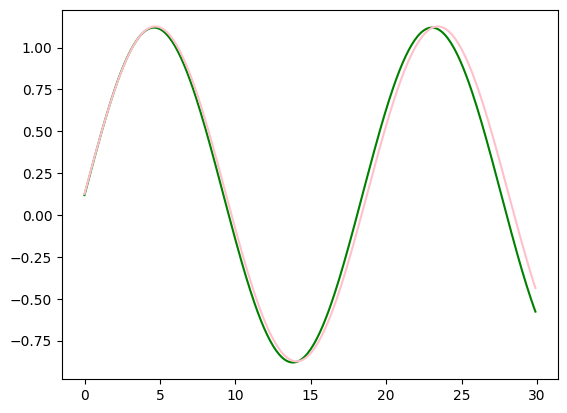

In [367]:
# Using hidden layer less than output dim

model = MyModel(input_dim=input_dim,
                hidden_dim=1,
                num_layers=1,
                seq_len=seq_len,
                output_dim=2, # y shape
                bidirectional=False)

train(model, train_x, train_y)
test(model, test_x, test_y)

To think: Less overfitting maybe?

## LSTM with variable input size

torch.Size([200, 300, 1])
torch.Size([200, 2])


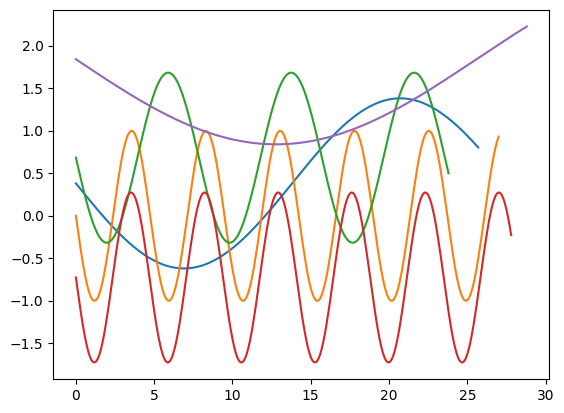

In [386]:
count = 200
max_seq_len = 300

all_x = []
all_y = []
seq_lengths = []

for i in range(count):
    seq_len = torch.randint(max_seq_len-100, max_seq_len, (1,))[0]
    points = torch.arange(seq_len) / 10
    y = torch.randn(2)
    x = torch.sin(points * y[0]) + y[1]

    if i < 5:
        plt.plot(points, x)
        
    seq_lengths.append(seq_len)
    # Pad x 
    padded_x = nn.functional.pad(x, (0, max_seq_len-seq_len,))
    assert padded_x.shape == (max_seq_len,)

    all_x.append(padded_x)
    all_y.append(y)

all_x = torch.concat(all_x).reshape(count, -1, 1)
all_y = torch.concat(all_y).reshape(count, -1)

print(all_x.shape)
print(all_y.shape)
    
# max_seq_len is prefined but there might be no sequence of that length
real_max_seq_len = max(seq_lengths)

In [402]:
batch_size = int(count * 0.8)
train_x, test_x = all_x[:batch_size], all_x[batch_size:]
train_y, test_y = all_y[:batch_size], all_y[batch_size:]
train_seq_len, test_seq_len = seq_lengths[:batch_size], seq_lengths[batch_size:]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([160, 300, 1]) torch.Size([160, 2])
torch.Size([40, 300, 1]) torch.Size([40, 2])


We can use `pack_padded_sequence` for passing sequence of different lengths to LSTM:

In [412]:
lstm_input_train = nn.utils.rnn.pack_padded_sequence(train_x, train_seq_len, batch_first=True, enforce_sorted=False)
lstm_input_test = nn.utils.rnn.pack_padded_sequence(test_x, test_seq_len, batch_first=True, enforce_sorted=False)

print(lstm_input_train.data.shape)
assert lstm_input_train.data.shape[0] == sum(train_seq_len)

torch.Size([39823, 1])


In [405]:
lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=False,
            batch_first=True
        )

lstm_output, h = lstm(lstm_input_train)
lstm_output.data.shape

torch.Size([39823, 2])

In [406]:
type(lstm_input_train)

torch.nn.utils.rnn.PackedSequence

The output is also of type `PackedSequence` and can be unpackked using `pad_packed_sequence`:

In [407]:
seq_unpacked, lens_unpacked = nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first=True)
print(seq_unpacked.shape, lens_unpacked.shape)

torch.Size([160, 299, 2]) torch.Size([160])


In [ ]:
class MyPaddedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional, seq_len, output_dim):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        
        D = 2 if bidirectional else 1
        
        self.linear = nn.Linear(seq_len*hidden_dim*D, output_dim)
        
    def forward(self, x):
        is_padded = isinstance(x, torch.nn.utils.rnn.PackedSequence)
        
        out, _ = self.lstm(x)
        
        if is_padded:
            out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
            
        reshaped_out = out.reshape(out.shape[0], -1)
        return self.linear(reshaped_out)
    


Epoch 0 | Loss: 1.0621881484985352
Epoch 1 | Loss: 0.820562481880188
Epoch 2 | Loss: 0.5509956479072571
Epoch 3 | Loss: 0.6716715693473816
Epoch 4 | Loss: 0.6345726847648621
Epoch 5 | Loss: 0.5954619646072388
Epoch 6 | Loss: 0.5331422686576843
Epoch 7 | Loss: 0.46967530250549316
Epoch 8 | Loss: 0.43340641260147095
Epoch 9 | Loss: 0.41908717155456543
Epoch 10 | Loss: 0.4111444056034088
Epoch 11 | Loss: 0.40373721718788147
Epoch 12 | Loss: 0.39567187428474426
Epoch 13 | Loss: 0.38560354709625244
Epoch 14 | Loss: 0.37204933166503906
Epoch 15 | Loss: 0.3531213104724884
Epoch 16 | Loss: 0.3283918499946594
Epoch 17 | Loss: 0.3014642596244812
Epoch 18 | Loss: 0.279556006193161
Epoch 19 | Loss: 0.2692955434322357
Epoch 20 | Loss: 0.2704995274543762
Epoch 21 | Loss: 0.27384400367736816
Epoch 22 | Loss: 0.2683762311935425
Epoch 23 | Loss: 0.25207972526550293
Epoch 24 | Loss: 0.2322283685207367
Epoch 25 | Loss: 0.21688303351402283
Epoch 26 | Loss: 0.20842818915843964
Epoch 27 | Loss: 0.2040997296

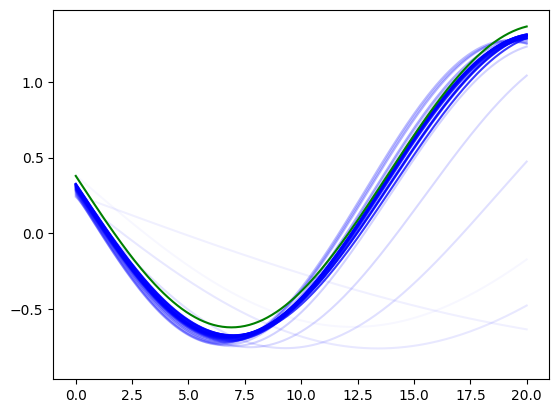

Test loss: 0.05314565822482109


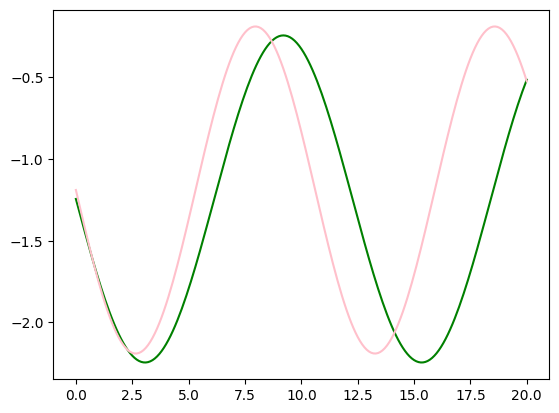

In [413]:

model = MyPaddedModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=1,
                seq_len=real_max_seq_len,
                output_dim=2, # y shape
                bidirectional=False)

train(model, lstm_input_train, train_y)
test(model, lstm_input_test, test_y)

Epoch 0 | Loss: 0.9669901132583618
Epoch 1 | Loss: 1.902822732925415
Epoch 2 | Loss: 0.7513806223869324
Epoch 3 | Loss: 0.6717060804367065
Epoch 4 | Loss: 1.0360190868377686
Epoch 5 | Loss: 1.0034228563308716
Epoch 6 | Loss: 0.7073184251785278
Epoch 7 | Loss: 0.4797086715698242
Epoch 8 | Loss: 0.4474232792854309
Epoch 9 | Loss: 0.5263997316360474
Epoch 10 | Loss: 0.5752994418144226
Epoch 11 | Loss: 0.5413762331008911
Epoch 12 | Loss: 0.465046226978302
Epoch 13 | Loss: 0.4019949436187744
Epoch 14 | Loss: 0.37245023250579834
Epoch 15 | Loss: 0.36437302827835083
Epoch 16 | Loss: 0.35818976163864136
Epoch 17 | Loss: 0.34421205520629883
Epoch 18 | Loss: 0.32441478967666626
Epoch 19 | Loss: 0.3054533898830414
Epoch 20 | Loss: 0.2933019995689392
Epoch 21 | Loss: 0.28939348459243774
Epoch 22 | Loss: 0.2870878577232361
Epoch 23 | Loss: 0.2755766808986664
Epoch 24 | Loss: 0.25149184465408325
Epoch 25 | Loss: 0.2250603437423706
Epoch 26 | Loss: 0.21129384636878967
Epoch 27 | Loss: 0.2140981703996

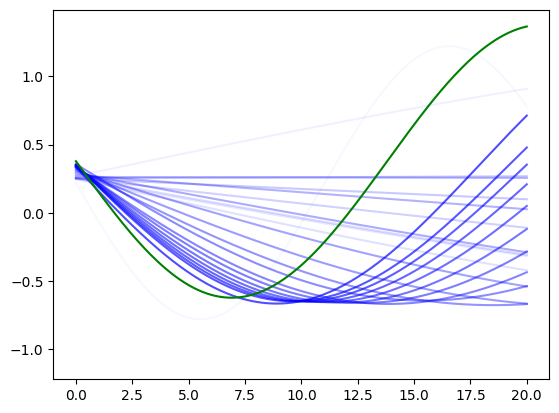

Test loss: 0.3361866772174835


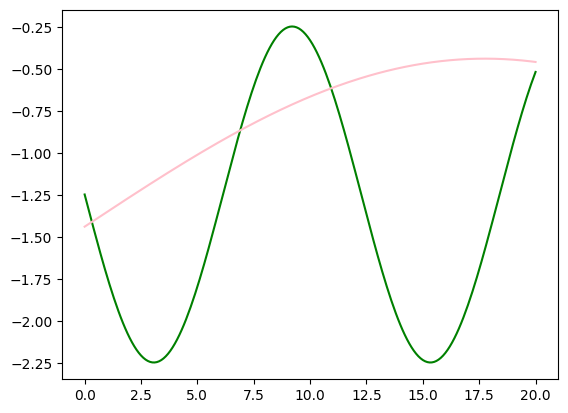

In [414]:
# bidirectional 

model = MyPaddedModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=1,
                seq_len=real_max_seq_len,
                output_dim=2, # y shape
                bidirectional=True)

train(model, lstm_input_train, train_y)
test(model, lstm_input_test, test_y)

Epoch 0 | Loss: 1.0003175735473633
Epoch 1 | Loss: 2.0549700260162354
Epoch 2 | Loss: 0.9297439455986023
Epoch 3 | Loss: 1.4200959205627441
Epoch 4 | Loss: 1.372833490371704
Epoch 5 | Loss: 1.0474265813827515
Epoch 6 | Loss: 0.9109681844711304
Epoch 7 | Loss: 0.9021471738815308
Epoch 8 | Loss: 0.8760355710983276
Epoch 9 | Loss: 0.8129016160964966
Epoch 10 | Loss: 0.7674254775047302
Epoch 11 | Loss: 0.7670919895172119
Epoch 12 | Loss: 0.7229078412055969
Epoch 13 | Loss: 0.6030852198600769
Epoch 14 | Loss: 0.5319464802742004
Epoch 15 | Loss: 0.5740744471549988
Epoch 16 | Loss: 0.6084448099136353
Epoch 17 | Loss: 0.5739516019821167
Epoch 18 | Loss: 0.5572273135185242
Epoch 19 | Loss: 0.5778048038482666
Epoch 20 | Loss: 0.5649422407150269
Epoch 21 | Loss: 0.5249437689781189
Epoch 22 | Loss: 0.5021388530731201
Epoch 23 | Loss: 0.5023717880249023
Epoch 24 | Loss: 0.5067161321640015
Epoch 25 | Loss: 0.5019001364707947
Epoch 26 | Loss: 0.4872828423976898
Epoch 27 | Loss: 0.4690970480442047
Epo

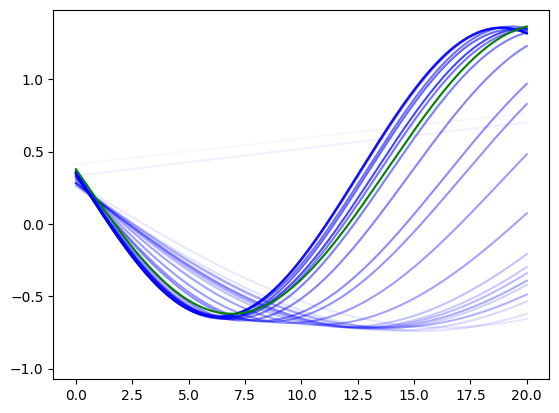

Test loss: 0.10795267671346664


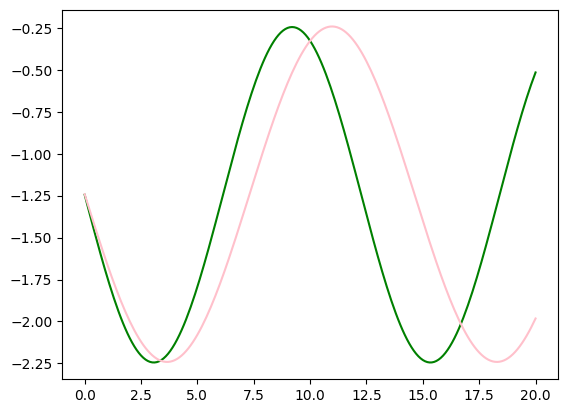

In [415]:
# Using more layers

model = MyPaddedModel(input_dim=input_dim,
                hidden_dim=2,
                num_layers=3,
                seq_len=real_max_seq_len,
                output_dim=2, # y shape
                bidirectional=True)

train(model, lstm_input_train, train_y)
test(model, lstm_input_test, test_y)